___
<img style="float: left; margin: 30px 15px 15px 15px;" src="https://d33wubrfki0l68.cloudfront.net/4ec62c1c925a380c912ddad740d18554c6822a11/fabe4/img/sponsors/iteso-university.png" width="300" height="500" /> 
    
    
### <font color='navy'> Modelado de pronóstico de series de tiempo. 

**Nombres:** José Luis Almendarez González, Marcela Quintero Pérez.

**Fecha:** 15 de mayo del 2025.

**Expediente** : 717644.

**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: [Repositorio del proyecto - Señales EEG](https://github.com/Marcelaqprz/mnl_proyecto)

# Cerebro en Serie: Modelado y Clasificación de Señales EEG con Técnicas Clásicas y Neuronales

![Portada](https://picower.mit.edu/sites/default/files/styles/hero_1x_wide/public/Brain%20Waves%20Head%20%28web%29.jpg?h=637ed8fe&itok=GIplEvtg)

# Introducción

Las señales `electroencefalográficas (EEG)` capturan la actividad eléctrica del cerebro a través de sensores colocados sobre el cuero cabelludo, generando series de tiempo multicanal altamente complejas, no lineales y ruidosas. Este proyecto tiene como objetivo aplicar un enfoque integral de modelado de series de tiempo a mediciones EEG obtenidas mediante 19 sensores, con el fin de analizar, pronosticar y clasificar patrones neuronales.

En la primera parte del proyecto, se selecciona una señal EEG univariada para construir un modelo clásico de pronóstico basado en SARIMAX. Esto permite establecer una línea base en cuanto al comportamiento temporal de las ondas cerebrales, empleando métricas como MAPE, MSE y R² para evaluar su desempeño.

Posteriormente, se implementan y comparan distintos modelos neuronales (MLP, CNN, LSTM y CNN-LSTM) en escenarios tanto univariados como multivariados. Se entrena cada modelo utilizando múltiples arquitecturas, seleccionando y optimizando la mejor configuración a través de técnicas automáticas de ajuste de hiperparámetros como Optuna. Esta etapa resalta el valor del aprendizaje profundo en la captura de relaciones temporales y espaciales complejas presentes en las señales EEG.

Finalmente, se aborda el problema desde una perspectiva de clasificación. Para ello, se selecciona una nueva base de datos enfocada específicamente en clasificar patrones de ondas cerebrales, o bien se transforma el problema de regresión anterior en una clasificación de tendencias cerebrales (como "alta actividad", "estable", "baja actividad"). Se implementan modelos neuronales y algoritmos clásicos de Machine Learning para comparar su rendimiento en tareas de clasificación multiclase.

In [3]:
# Librerías
import itertools
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    ConvLSTM2D,
    Dense,
    Flatten,
    InputLayer,
    LSTM,
    MaxPooling1D,
    Reshape,
    TimeDistributed
)
from tensorflow.keras.models import Sequential

# Configuración
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
seed = 123

In [4]:
df = pd.read_pickle("eeg_sintetico.pkl")

df.head(5)

,subject_id,label,FP1,FP2,F7,F8,F3,F4,T3,T4,...,C4,T5,T6,P3,P4,O1,O2,Fz,Cz,Pz
0,0,1,"[0.15587447800554355, 0.048769292252935546, 0....","[-0.6968879461070122, 0.3041051323704602, -0.2...","[0.21046417445643764, -0.5011039978323505, 0.2...","[0.18303634326083004, 0.749975949403681, -0.41...","[0.015935616742674418, -0.4551790928562453, 0....","[-0.3906596334901174, -0.14372275137743712, -0...","[0.2061201754827602, 0.26261352060634746, 0.55...","[0.5150697349605693, 0.020121574552339695, 0.2...",...,"[-0.40108551421875016, 0.888215263654424, 0.06...","[0.14658695189976664, 0.3196109608103265, 0.22...","[-0.18113293859735952, -0.294840608341252, -0....","[0.1386998531603244, 0.4047252273721315, 0.039...","[-0.09162155206774368, -0.5130820276219235, -0...","[0.35194813407593795, -0.024736035982895078, -...","[0.18086983683763597, -0.13258454793621965, 0....","[0.2950850184403256, -0.49017985528384994, 0.4...","[-0.24632716894730672, -0.4725025004401394, -0...","[-0.1756804040692081, -0.02965044501952376, 0...."
1,1,1,"[-0.03979021103450947, -0.15409787416001966, 0...","[-0.024155503243054738, -0.15408441134477466, ...","[-0.3886884401035693, -0.005604558802166581, -...","[-0.24523298784390293, -0.6000420524696534, -0...","[0.11066005471842116, 0.5110741339575443, -0.0...","[0.33077560454690697, -0.24159651232014817, 0....","[0.34660487797241823, -0.039803236740678996, 0...","[0.02580488016898886, 0.18312879701770632, -0....",...,"[0.04148731827688728, -0.4147464802531556, 0.4...","[-0.00736988370343126, -0.28822981134508396, 0...","[-0.19501003683079532, 0.38585018662985887, 0....","[-0.08849100491022789, 0.20587977222299944, -0...","[0.3196469240800905, 0.8507797255650871, -0.43...","[-0.5802213149079919, 0.38811112920811786, -0....","[0.3875610412004299, -0.45831180964543644, -0....","[0.030784914240578564, 0.04455984603183623, -0...","[-0.3852053398712488, 0.05830688683541568, -0....","[-0.11758727562431871, -0.1776706278108205, 0...."
2,2,1,"[-0.7308852577782832, 0.6331634483447823, 0.18...","[0.14340017834713065, -0.41708651789155976, -0...","[0.5997492234290559, -0.26547970400070653, -0....","[0.2524784363902365, -0.27995076798093665, 0.1...","[0.4223506579931446, 0.40185920250899615, -0.0...","[0.7281394235840116, -0.5087121383215768, 0.46...","[-0.7755418652479512, -0.0788045211090522, -0....","[-0.6808254913360005, 0.0024041062399791273, 0...",...,"[0.2247150984377684, -0.07912830588442449, -0....","[0.010792093762172755, 0.6388023807499378, -0....","[-0.7910330202396902, 0.5322224926701894, 0.09...","[0.896112963081652, 0.2259160601161496, -0.850...","[-0.6171890406969667, -0.001500307615138619, -...","[0.7174894105901409, 0.3102244820488897, 0.104...","[0.017696120108697345, 0.609504496434134, 0.36...","[-0.09255084527561272, -0.3383512050992671, 0....","[-0.4079899243538443, -0.40957857315730495, -0...","[0.2693127846006996, 0.8492481791217846, 0.125..."
3,3,1,"[0.13926135016669713, 0.31341738685791276, -0....","[0.7251229185054089, 0.05740628040619821, 0.62...","[0.10858850675719665, -0.15933229941815893, -0...","[0.0168885887953725, 0.09756864990030252, 0.50...","[-0.30985037940465965, 0.18449691148771832, 0....","[0.03875734841802368, -0.005762306493915205, 0...","[0.11295279464044487, 0.19612264223823347, 0.0...","[-0.35660276445858197, 0.24687397929716368, 0....",...,"[0.5614452962438603, -0.3916662485849009, 0.35...","[-0.16242306237856635, -0.3622261056353095, -0...","[-0.37409621666022697, 0.197470025712021, 0.29...","[-0.532842898115002, -0.46019606784703526, -0....","[0.0339680712018202, -0.23731137069794478, -0....","[-0.04048277265618861, 0.4552294299090003, 0.3...","[-0.342336720037937, 0.01792720335064462, 0.01...","[-0.31256621264992845, 0.19301301663607726, 0....","[-0.026360605283680373, 0.2761337835145571, 0....","[0.40361547200099324, -0.020764812083308642, -..."
4,4,2,"[-0.057672758871040994, 0.021908782999175317, ...","[-0.04708345796920925, 0.0028591800521007753, ...","[-0.0021487455704599684, 0.

# Desarrollo

Las señales utilizadas en este proyecto provienen de registros EEG multicanal, obtenidos mediante un conjunto de 19 sensores dispuestos sobre el cuero cabelludo de cada sujeto. La colocación de los sensores sigue típicamente el estándar internacional 10-20, utilizado ampliamente en neurociencia clínica e investigativa para garantizar la replicabilidad y consistencia espacial de las mediciones.

Cada canal (sensor) registra la actividad eléctrica cerebral en una ubicación específica, reflejando fenómenos neuronales relacionados con funciones motoras, cognitivas o sensoriales, dependiendo del área cortical correspondiente. Estas señales conforman series temporales continuas con alta resolución temporal y pueden verse afectadas por ruido, artefactos y variaciones individuales, lo que hace crucial el uso de técnicas robustas para su modelado y análisis.

A continuación, se presenta una imagen referencial de la disposición típica de los electrodos en un registro EEG:

![EEG](https://www.researchgate.net/profile/Iqram-Hussain/publication/346700844/figure/fig2/AS:966299295440896@1607395113741/Description-of-device-electrodes-layout-used-in-experiment-a-positions-of-EEG.png)


## 1. Análisis y pronóstico de series de tiempo
Obj: Mostrar competencia de aprendizaje Modelos lineales de regresión

In [5]:
sensor_cols = ['FP1', 'FP2', 'F7', 'F8', 'F3', 'F4', 'T3', 'T4',
               'C3', 'C4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2',
               'Fz', 'Cz', 'Pz']

# Asegurar que todas las columnas contengan arrays de NumPy
for col in sensor_cols:
    df[col] = df[col].apply(lambda x: np.array(x) if not isinstance(x, np.ndarray) else x)

# Calcular la media por sujeto (por fila), punto a punto
df['wave_mean'] = df[sensor_cols].apply(lambda row: np.mean(np.vstack(row.values), axis=0), axis=1)

In [6]:
# Elegir una fila aleatoria del DataFrame
random_row = df.iloc[93]

# Obtener la señal
wave = random_row.wave_mean
# Crear eje de tiempo (de 1 a 2000)
t = np.arange(1, len(wave) + 1)
# Crear DataFrame de la serie de tiempo
ts = pd.Series(wave, index=t)
ts.index = pd.date_range(start="2020-01-01", periods=len(ts), freq="D")
ts

2020-01-01   -0.008081
2020-01-02   -0.022480
2020-01-03    0.043144
2020-01-04    0.077575
2020-01-05    0.046199
                ...   
2025-06-18    0.488267
2025-06-19    0.506256
2025-06-20    0.450273
2025-06-21    0.499471
2025-06-22    0.486438
Freq: D, Length: 2000, dtype: float64

<Axes: >

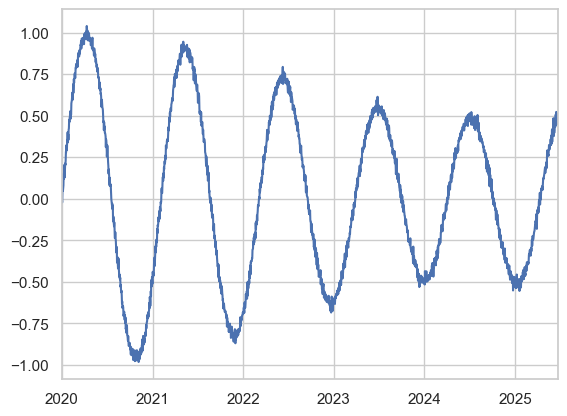

In [7]:
ts.plot()

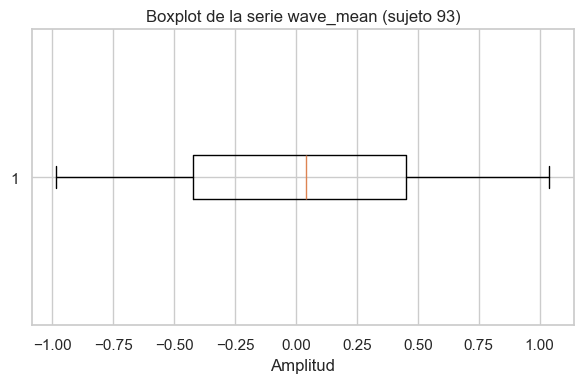

In [8]:
plt.figure(figsize=(6, 4))
plt.boxplot(ts, vert=False)
plt.title("Boxplot de la serie wave_mean (sujeto 93)")
plt.xlabel("Amplitud")

plt.tight_layout()
plt.show()

A continuación, se realiza un reescalado de la serie al rango [0,1] para garantizar que todos los valores sean positivos, condición necesaria para aplicar la transformación de Box-Cox. Esta transformación busca estabilizar la varianza y acercar la distribución de los datos a una forma aproximadamente normal, lo cual resulta especialmente útil para modelos lineales y redes neuronales sensibles a la distribución de entrada. Finalmente, se aplica un pequeño desplazamiento hacia arriba para asegurar que todos los valores transformados permanezcan estrictamente positivos y evitar problemas numéricos durante el procesamiento.

<Axes: title={'center': 'Box-Cox (shifted positive)'}>

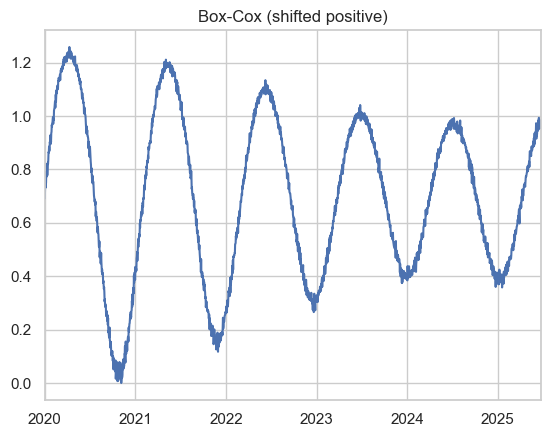

In [10]:
ts_rescaled = (ts + 1) / 2  # Esto asegura que -1 → 0 y 1 → 1
from scipy import stats

ts_boxcox, lambda_ = stats.boxcox(ts_rescaled)
ts_boxcox = pd.Series(ts_boxcox, index=ts.index)

ts_boxcox_shifted = ts_boxcox - ts_boxcox.min() + 1e-5
ts_boxcox_shifted.plot(title="Box-Cox (shifted positive)")

Graficamos de nuevo el box-plot para corroborar la escala del gráfico:

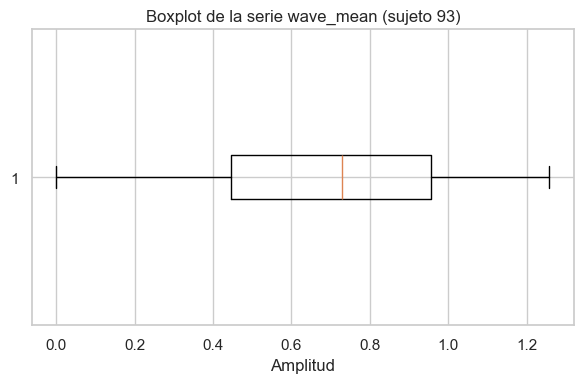

In [12]:
plt.figure(figsize=(6, 4))
plt.boxplot(ts_boxcox_shifted, vert=False)
plt.title("Boxplot de la serie wave_mean (sujeto 93)")
plt.xlabel("Amplitud")

plt.tight_layout()
plt.show()

Para evaluar la estacionariedad de la serie de tiempo, se aplica el test de Dickey-Fuller Aumentado (ADF). Esta prueba estadística nos permite verificar si una serie presenta una raíz unitaria, lo que indicaría que es no estacionaria. En términos prácticos, la estacionariedad implica que las propiedades estadísticas de la serie (como la media y la varianza) son constantes a lo largo del tiempo, lo cual es una premisa clave para muchos modelos de pronóstico.

Si el p-valor de la prueba ADF es bajo (generalmente menor a 0.05), podemos rechazar la hipótesis nula de que la serie tiene una raíz unitaria, lo que indica que la serie es estacionaria. Esto significa que la serie no necesita ser transformada adicionalmente antes de aplicar modelos como ARIMA o redes neuronales.

En cambio, si el p-valor es alto, no podemos rechazar la hipótesis nula y, por lo tanto, la serie se considera no estacionaria. En este caso, puede ser necesario aplicar técnicas adicionales como diferenciación o transformaciones (como el logaritmo o la Box-Cox) para hacer la serie estacionaria antes de continuar con el modelado.

In [13]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [14]:
adf_test(ts_boxcox_shifted)

Results of Dickey-Fuller Test:
Test Statistic                -1.298482e+01
p-value                        2.893004e-24
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64
Stationary


Tras aplicar el test de Dickey-Fuller Aumentado (ADF), se ha confirmado que la serie de tiempo es estacionaria, con un p-valor de 2.89e-24, lo que permite rechazar la hipótesis nula de la presencia de una raíz unitaria. Esto indica que la serie cumple con los requisitos necesarios para aplicar modelos como SARIMAX, los cuales son adecuados para series de tiempo con componentes estacionales y dependencias temporales.

El siguiente paso en el análisis es realizar una descomposición MSTL (Seasonal-Trend decomposition using Loess), que nos permitirá descomponer la serie en sus componentes clave: estacionalidad, tendencia y residuales. Esta descomposición es esencial para entender mejor los patrones subyacentes de la serie y para asegurar que los efectos estacionales sean capturados adecuadamente antes de ajustar el modelo.

Luego de obtener los componentes estacionales, de tendencia y residuales, se realiza nuevamente el test ADF sobre cada uno de ellos para confirmar que no existan problemas de no estacionariedad que puedan afectar la modelización futura. La descomposición no solo facilita una mejor comprensión de la dinámica de la serie, sino que también puede ofrecer pistas sobre qué componentes estacionales deben ser modelados de manera específica en el SARIMAX. Así, aseguramos que el modelo pueda capturar tanto las dependencias de corto plazo como los efectos estacionales, lo que maximiza su capacidad predictiva.

In [15]:
def mstl_descomposition(data, periods_seasonality, stl_kwargs=None):
    if stl_kwargs is None:
        stl_kwargs = {"seasonal_deg": 0}

    model = MSTL(data, periods=periods_seasonality, stl_kwargs=stl_kwargs)
    res = model.fit()

    fig, ax = plt.subplots(3 + len(periods_seasonality), 1, sharex=True, figsize=(8, 8))

    res.observed.plot(ax=ax[0])
    ax[0].set_ylabel('Observed')

    res.trend.plot(ax=ax[1])
    ax[1].set_ylabel('Trend')

    for i, s_period in enumerate(periods_seasonality):
        res.seasonal[f'seasonal_{s_period}'].plot(ax=ax[i + 2])
        ax[i + 2].set_ylabel(f'seasonal_{s_period}')

    res.resid.plot(ax=ax[2 + len(periods_seasonality)])
    ax[2 + len(periods_seasonality)].set_ylabel('Residual')

    fig.tight_layout()
    return res

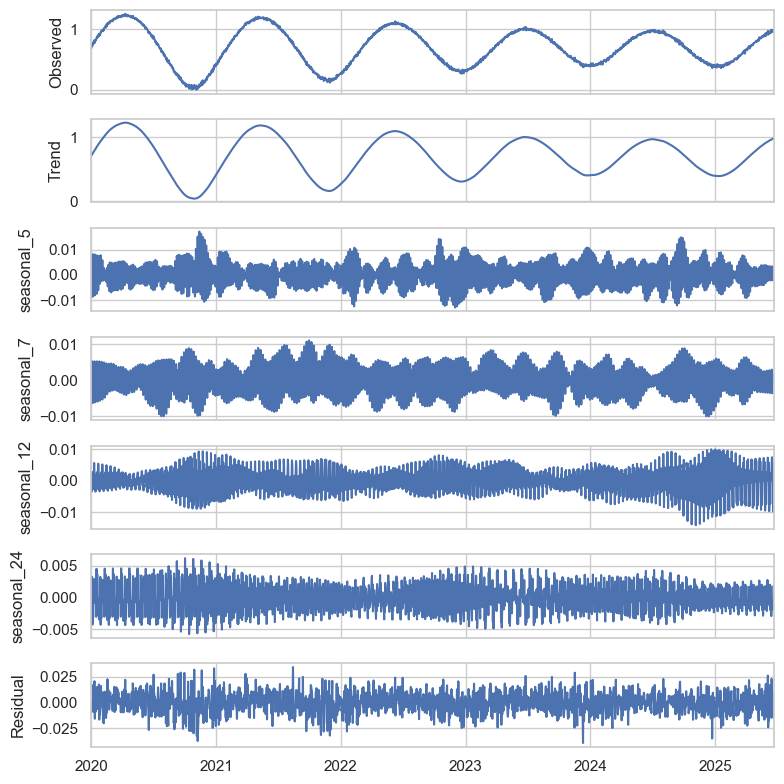

In [16]:
periods_seasonality = (5 ,7 ,12, 24)

desc = mstl_descomposition(ts_boxcox_shifted, periods_seasonality)

In [17]:
# Lista de los componentes estacionales y residuales
components = ['seasonal_5', 'seasonal_7', 'seasonal_12', 'seasonal_24', 'residuals']

# Iterar sobre los componentes y aplicar el test ADF
for component in components:
    print(f"\n{component}")
    # Si el componente no está en 'desc.seasonal', usa 'desc.resid'
    adf_test(desc.seasonal.get(component, desc.resid))  
    print()


seasonal_5
Results of Dickey-Fuller Test:
Test Statistic                  -19.202710
p-value                           0.000000
#Lags Used                       25.000000
Number of Observations Used    1974.000000
Critical Value (1%)              -3.433667
Critical Value (5%)              -2.863005
Critical Value (10%)             -2.567550
dtype: float64
Stationary


seasonal_7
Results of Dickey-Fuller Test:
Test Statistic                -1.335810e+01
p-value                        5.496851e-25
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64
Stationary


seasonal_12
Results of Dickey-Fuller Test:
Test Statistic                -1.621373e+01
p-value                        3.962143e-29
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -

Con base en estos resultados, podemos concluir que todos los componentes estacionales y los residuos de la serie son estacionarios, lo que significa que la serie de tiempo es adecuada para ser modelada con métodos como SARIMAX, sin necesidad de transformaciones adicionales de diferenciación. La confirmación de la estacionariedad de los residuos es particularmente importante, ya que garantiza que no hay patrones temporales no capturados que puedan influir en el modelo.

Ahora, con la serie ya comprobada como estacionaria, el siguiente paso es realizar un análisis de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar los parámetros adecuados del modelo AR (autoregresivo) y MA (media móvil). Esto nos ayudará a ajustar el modelo SARIMAX y a capturar las dependencias temporales y los efectos estacionales de manera más precisa.

In [19]:
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

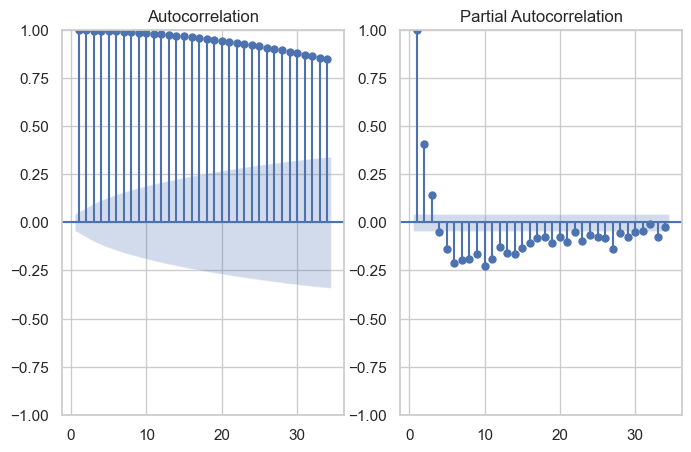

In [20]:
plot_acf_pacf(ts_boxcox_shifted)

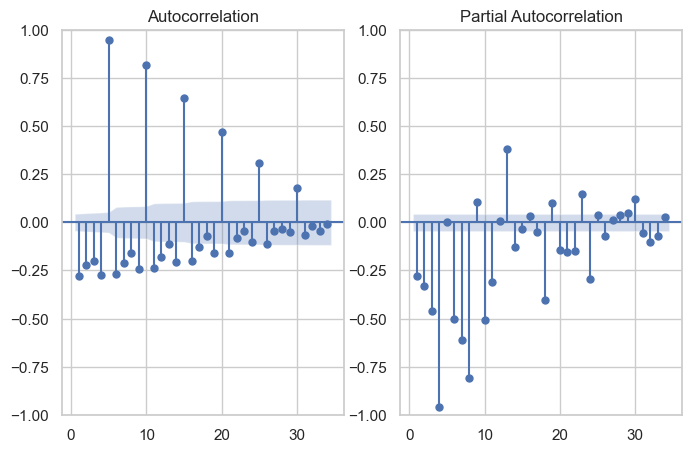

In [21]:
plot_acf_pacf(desc.seasonal['seasonal_5'])

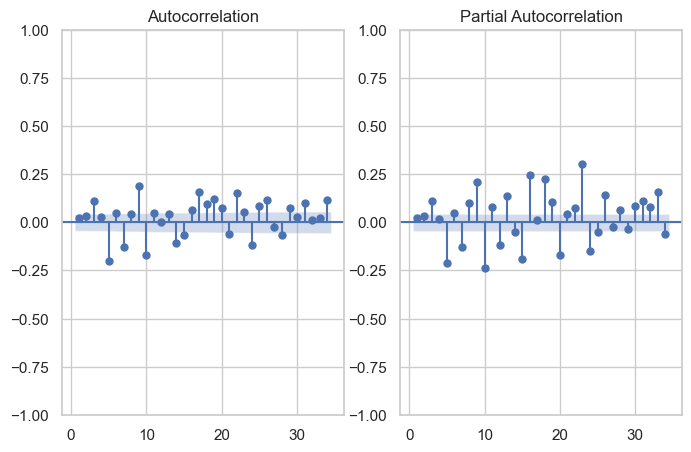

In [22]:
plot_acf_pacf(desc.resid)

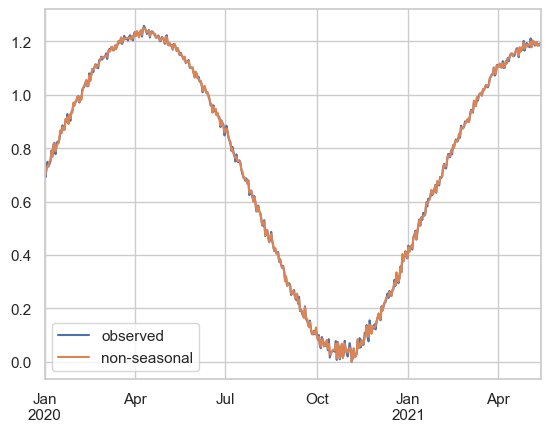

In [23]:
non_seasonal = desc.observed - desc.seasonal['seasonal_5'] - desc.seasonal['seasonal_7']

desc.observed[:500].plot()
non_seasonal[:500].plot()
plt.legend(['observed', 'non-seasonal'])

In [24]:
adf_test(non_seasonal)

Results of Dickey-Fuller Test:
Test Statistic                -1.314541e+01
p-value                        1.401610e-24
#Lags Used                     2.600000e+01
Number of Observations Used    1.973000e+03
Critical Value (1%)           -3.433669e+00
Critical Value (5%)           -2.863006e+00
Critical Value (10%)          -2.567550e+00
dtype: float64
Stationary


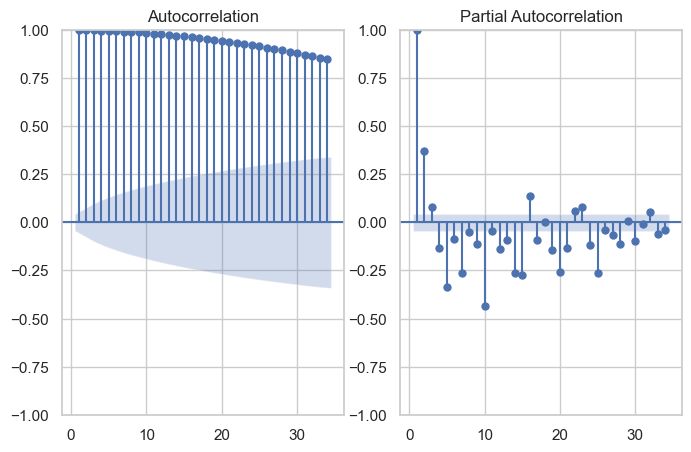

In [25]:
plot_acf_pacf(non_seasonal)

In [ ]:
n_train = int(0.8 * len(ts_boxcox_shifted))
n_test = len(ts_boxcox_shifted) - n_train

train_data_opt = ts_boxcox_shifted[:n_train]
test_data_opt = ts_boxcox_shifted[-n_test:]

# Crear características de seno y coseno
ts_sin = np.sin(np.linspace(0, len(train_data_opt), len(train_data_opt)))
ts_cos = np.cos(np.linspace(0, len(train_data_opt), len(train_data_opt)))

# Añadir las características al modelo
train_data_opt = pd.DataFrame({
    'sin_component': ts_sin,
    'cos_component': ts_cos,
    'target': train_data_opt
})

# Crear características de seno y coseno para test
ts_sin_test = np.sin(np.linspace(len(train_data_opt), len(train_data_opt) + len(test_data_opt), len(test_data_opt)))
ts_cos_test = np.cos(np.linspace(len(train_data_opt), len(train_data_opt) + len(test_data_opt), len(test_data_opt)))

test_exog = pd.DataFrame({
    'sin_component': ts_sin_test,
    'cos_component': ts_cos_test
}, index=test_data_opt.index)  # importante mantener el índice

In [27]:
# Suponiendo que `ts` es tu serie temporal
model = SARIMAX(
    train_data_opt['target'],
    exog=train_data_opt[['sin_component', 'cos_component']],
    order=(1, 1, 2),
    seasonal_order=(3, 2, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())


                                      SARIMAX Results                                      
Dep. Variable:                              target   No. Observations:                 1600
Model:             SARIMAX(1, 1, 2)x(3, 2, [1], 7)   Log Likelihood                4080.322
Date:                             Tue, 13 May 2025   AIC                          -8140.645
Time:                                     21:56:47   BIC                          -8087.101
Sample:                                 01-01-2020   HQIC                         -8120.739
                                      - 05-18-2024                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
sin_component    -0.0005      0.000     -1.509      0.131      -0.001       0.000
cos_component    -

RMSE (Box-Cox): 0.9510
MAE  (Box-Cox): 0.8275


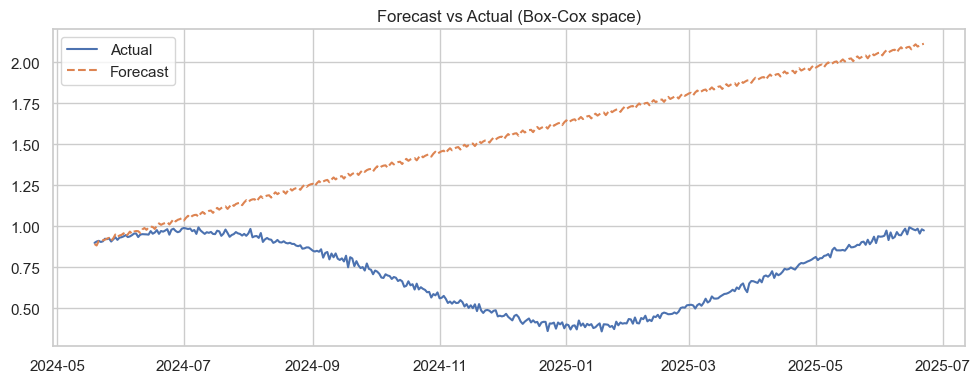

In [28]:
# 2. Predicción
forecast = results.get_forecast(steps=len(test_data_opt), exog=test_exog)
predicted_mean = forecast.predicted_mean

# 3. Evaluación
rmse = np.sqrt(mean_squared_error(test_data_opt, predicted_mean))
mae = mean_absolute_error(test_data_opt, predicted_mean)

print(f'RMSE (Box-Cox): {rmse:.4f}')
print(f'MAE  (Box-Cox): {mae:.4f}')

# Graficar
plt.figure(figsize=(10, 4))
plt.plot(test_data_opt.index, test_data_opt, label='Actual')
plt.plot(test_data_opt.index, predicted_mean, label='Forecast', linestyle='--')
plt.title('Forecast vs Actual (Box-Cox space)')
plt.legend()
plt.tight_layout()
plt.show()



In [51]:
# Define los rangos máximos (basado en tus valores)
p = [1,2,3]
d = [1,2,3]
q = [1,2,3]

P = [3]
D = [2]
Q = [1]

s = 7  # Periodo estacional

# Generar todas las combinaciones posibles
orders = list(itertools.product(p, d, q))
seasonal_orders = list(itertools.product(P, D, Q))

# Inicializar variables para almacenar el mejor modelo
best_rmse = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# Loop de búsqueda
for order in orders:
    for seasonal in seasonal_orders:
        try:
            model = SARIMAX(train_data_opt,
                            order=order,
                            seasonal_order=(seasonal[0], seasonal[1], seasonal[2], s),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            # 2. Predicción
            forecast = results.get_forecast(steps=len(test_data_opt))
            predicted_mean = forecast.predicted_mean

            # 3. Evaluación
            rmse = np.sqrt(mean_squared_error(test_data_opt, predicted_mean))
            mae = mean_absolute_error(test_data_opt, predicted_mean)

            # Mostrar las métricas de rendimiento
            print(f"Modelo SARIMA{order} x {seasonal}7")
            print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f}")

            # Graficar la predicción vs la realidad (en escala Box-Cox)
            plt.figure(figsize=(10, 4))
            plt.plot(test_data_opt.index, test_data_opt, label='Actual')
            plt.plot(test_data_opt.index, predicted_mean, label='Forecast', linestyle='--')
            plt.title(f'Forecast vs Actual (SARIMA{order} x {seasonal}7)')
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Si el modelo actual tiene un RMSE menor, lo actualizamos como el mejor
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal
                best_model = results
                print(f"NUEVO MEJOR MODELO: SARIMA{order} x {seasonal}7 con RMSE={rmse:.4f}")

        except Exception as e:
            print(f"Error con orden={order} y seasonal={seasonal}: {e}")
            continue

print("\n--- Mejor modelo encontrado ---")
print(f"Orden: {best_order}")
print(f"Orden estacional: {best_seasonal_order}7")
print(f"RMSE: {best_rmse:.4f}")


Error con orden=(1, 1, 1) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 1, 2) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 1, 3) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 2, 1) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 2, 2) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 2, 3) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 3, 1) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 3, 2) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (1600, 3).
Error con orden=(1, 3, 3) y seasonal=(3, 2, 1): SARIMAX models require univariate `endog`. Got shape (16

## 2. Modelos neuronales para series de tiempo

#### a) Datos univariados:

In [30]:
def create_sequences(data, target_col='target', window_size=30, is_multivariate=False):
    """
    Crea ventanas de tiempo para modelos neuronales.

    Args:
        data (DataFrame): datos con columnas (target, posiblemente otras exógenas)
        target_col (str): nombre de la columna objetivo
        window_size (int): tamaño de la ventana de entrada
        is_multivariate (bool): si se trata de multivariado (varias features)

    Returns:
        X, y: tensores listos para alimentar modelos
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        features = data.iloc[i:i+window_size]
        target = data.iloc[i+window_size][target_col]
        if is_multivariate:
            X.append(features.drop(columns=[target_col]).values)
        else:
            X.append(features[target_col].values)
        y.append(target)
    return np.array(X), np.array(y)

In [31]:
# Usamos solo la columna 'target' para univariado
window_size = 30

X_train_uni, y_train_uni = create_sequences(train_data_opt, window_size=window_size, is_multivariate=False)
X_test_uni, y_test_uni = create_sequences(
    pd.DataFrame({
        'target': test_data_opt
    }), window_size=window_size, is_multivariate=False)

# Ajustar formas para MLP y LSTM
X_train_uni_mlp = X_train_uni.copy()
X_test_uni_mlp = X_test_uni.copy()

X_train_uni_lstm = X_train_uni.reshape((X_train_uni.shape[0], X_train_uni.shape[1], 1))
X_test_uni_lstm = X_test_uni.reshape((X_test_uni.shape[0], X_test_uni.shape[1], 1))

print(f"X_train_uni shape (MLP): {X_train_uni_mlp.shape}")
print(f"X_train_uni shape (LSTM): {X_train_uni_lstm.shape}")

X_train_uni shape (MLP): (1570, 30)
X_train_uni shape (LSTM): (1570, 30, 1)


#### b) Datos multivariados:

In [32]:
# Función para crear secuencias multivariadas
def create_multivariate_sequences(data, target_col='target', window_size=30):
    """
    Crea ventanas de tiempo multivariadas para modelos neuronales.

    Args:
        data (DataFrame): datos con múltiples columnas (target + exógenas)
        target_col (str): nombre de la columna objetivo
        window_size (int): tamaño de la ventana de entrada

    Returns:
        X, y: tensores listos para alimentar modelos multivariados
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        features = data.iloc[i:i+window_size]
        target = data.iloc[i+window_size][target_col]
        X.append(features.drop(columns=[target_col]).values)
        y.append(target)
    return np.array(X), np.array(y)

In [33]:
# Para el caso multivariado, incluimos todas las columnas de los sensores y las características
train_data_multi = pd.DataFrame({
    **train_data_opt[['sin_component', 'cos_component']],
    'target': train_data_opt['target']
})

test_data_multi = pd.DataFrame({
    **test_exog[['sin_component', 'cos_component']],
    'target': test_data_opt
})

# Crear secuencias para el caso multivariado
X_train_multi, y_train_multi = create_multivariate_sequences(train_data_multi, window_size=30)
X_test_multi, y_test_multi = create_multivariate_sequences(test_data_multi, window_size=30)

# Ajustar formas para MLP y LSTM
X_train_multi_mlp = X_train_multi.copy()
X_test_multi_mlp = X_test_multi.copy()

X_train_multi_lstm = X_train_multi.reshape((X_train_multi.shape[0], X_train_multi.shape[1], X_train_multi.shape[2]))
X_test_multi_lstm = X_test_multi.reshape((X_test_multi.shape[0], X_test_multi.shape[1], X_test_multi.shape[2]))

print(f"X_train_multi shape (MLP): {X_train_multi_mlp.shape}")
print(f"X_train_multi shape (LSTM): {X_train_multi_lstm.shape}")

X_train_multi shape (MLP): (1570, 30, 2)
X_train_multi shape (LSTM): (1570, 30, 2)


#### **Multilayer Perceptron (MLP)**

#### a) Datos univariados:

In [34]:
# Callback para todos los modelos
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Diccionario para guardar resultados
mlp_uni_results = {}
mlp_uni_models = {}

# Estructura 1
def mlp_uni_model_1(input_shape):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 2
def mlp_uni_model_2(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 3
def mlp_uni_model_3(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
mlp_uni_architectures = {
    "MLP_Uni_1": mlp_uni_model_1,
    "MLP_Uni_2": mlp_uni_model_2,
    "MLP_Uni_3": mlp_uni_model_3
}

# Entrenamiento y evaluación
for name, model_fn in mlp_uni_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn((X_train_uni_mlp.shape[1],))
    history = model.fit(
        X_train_uni_mlp, y_train_uni,
        validation_data=(X_test_uni_mlp, y_test_uni),
        epochs=100, batch_size=32,
        callbacks=[early_stopping], verbose=0
    )
    y_pred = model.predict(X_test_uni_mlp)
    mse = mean_squared_error(y_test_uni, y_pred)
    mlp_uni_results[name] = mse
    mlp_uni_models[name] = model
    print(f"{name} - MSE: {mse:.4f}")


Entrenando MLP_Uni_1...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MLP_Uni_1 - MSE: 0.0003

Entrenando MLP_Uni_2...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
MLP_Uni_2 - MSE: 0.0003

Entrenando MLP_Uni_3...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MLP_Uni_3 - MSE: 0.0002


#### b) Datos multivariados:

In [36]:
# Reformula los datos antes del ciclo de entrenamiento
X_train_multi_mlp = X_train_multi_mlp.reshape(X_train_multi_mlp.shape[0], -1)
X_test_multi_mlp = X_test_multi_mlp.reshape(X_test_multi_mlp.shape[0], -1)

In [37]:
# Callback común
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Diccionario para guardar resultados
mlp_multi_results = {}
mlp_multi_models = {}

# Estructura 1
def mlp_multi_model_1(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 2
def mlp_multi_model_2(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 3
def mlp_multi_model_3(input_shape):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
mlp_multi_architectures = {
    "MLP_Multi_1": mlp_multi_model_1,
    "MLP_Multi_2": mlp_multi_model_2,
    "MLP_Multi_3": mlp_multi_model_3
}

# Entrenamiento y evaluación
for name, model_fn in mlp_multi_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn((X_train_multi_mlp.shape[1],))
    history = model.fit(
        X_train_multi_mlp, y_train_multi,
        validation_data=(X_test_multi_mlp, y_test_multi),
        epochs=100, batch_size=32,
        callbacks=[early_stopping], verbose=0
    )
    y_pred = model.predict(X_test_multi_mlp)
    mse = mean_squared_error(y_test_multi, y_pred)
    mlp_multi_results[name] = mse
    mlp_multi_models[name] = model
    print(f"{name} - MSE: {mse:.4f}")


Entrenando MLP_Multi_1...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MLP_Multi_1 - MSE: 0.0462

Entrenando MLP_Multi_2...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MLP_Multi_2 - MSE: 0.0445

Entrenando MLP_Multi_3...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MLP_Multi_3 - MSE: 0.0437


#### **Convolutional Neural Network (CNN)**

#### a) Datos univariados: 

In [38]:
# Diccionarios para guardar resultados
cnn_uni_results = {}
cnn_uni_models = {}

# Estructura 1
def cnn_uni_model_1(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 2
def cnn_uni_model_2(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 3
def cnn_uni_model_3(input_shape):
    model = Sequential()
    model.add(Conv1D(128, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
cnn_uni_architectures = {
    "CNN_Uni_1": cnn_uni_model_1,
    "CNN_Uni_2": cnn_uni_model_2,
    "CNN_Uni_3": cnn_uni_model_3
}

# Entrenamiento y evaluación
for name, model_fn in cnn_uni_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn((X_train_uni_lstm.shape[1], X_train_uni_lstm.shape[2]))
    history = model.fit(
        X_train_uni_lstm, y_train_uni,
        validation_data=(X_test_uni_lstm, y_test_uni),
        epochs=100, batch_size=32,
        callbacks=[early_stopping], verbose=0
    )
    y_pred = model.predict(X_test_uni_lstm)
    mse = mean_squared_error(y_test_uni, y_pred)
    cnn_uni_results[name] = mse
    cnn_uni_models[name] = model
    print(f"{name} - MSE: {mse:.4f}")


Entrenando CNN_Uni_1...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
CNN_Uni_1 - MSE: 0.0002

Entrenando CNN_Uni_2...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
CNN_Uni_2 - MSE: 0.0002

Entrenando CNN_Uni_3...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
CNN_Uni_3 - MSE: 0.0002


#### b) Datos multivariados:

In [39]:
# Diccionarios para guardar resultados
cnn_multi_results = {}
cnn_multi_models = {}

# Estructura 1
def cnn_multi_model_1(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 2
def cnn_multi_model_2(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 3
def cnn_multi_model_3(input_shape):
    model = Sequential()
    model.add(Conv1D(128, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
cnn_multi_architectures = {
    "CNN_Multi_1": cnn_multi_model_1,
    "CNN_Multi_2": cnn_multi_model_2,
    "CNN_Multi_3": cnn_multi_model_3
}

# Entrenamiento y evaluación
for name, model_fn in cnn_multi_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn((X_train_multi.shape[1], X_train_multi.shape[2]))
    history = model.fit(
        X_train_multi, y_train_multi,
        validation_data=(X_test_multi, y_test_multi),
        epochs=100, batch_size=32,
        callbacks=[early_stopping], verbose=0
    )
    y_pred = model.predict(X_test_multi)
    mse = mean_squared_error(y_test_multi, y_pred)
    cnn_multi_results[name] = mse
    cnn_multi_models[name] = model
    print(f"{name} - MSE: {mse:.4f}")


Entrenando CNN_Multi_1...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
CNN_Multi_1 - MSE: 0.0434

Entrenando CNN_Multi_2...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
CNN_Multi_2 - MSE: 0.0433

Entrenando CNN_Multi_3...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
CNN_Multi_3 - MSE: 0.0433


#### **Long Short-Term Memory (LSTM)**

#### a) Datos univariados:

In [40]:
# Diccionarios para guardar resultados
lstm_uni_results = {}
lstm_uni_models = {}

# Estructura 1
def lstm_uni_model_1(input_shape):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 2
def lstm_uni_model_2(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 3
def lstm_uni_model_3(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
lstm_uni_architectures = {
    "LSTM_Uni_1": lstm_uni_model_1,
    "LSTM_Uni_2": lstm_uni_model_2,
    "LSTM_Uni_3": lstm_uni_model_3
}

# Entrenamiento y evaluación
for name, model_fn in lstm_uni_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn((X_train_uni_lstm.shape[1], X_train_uni_lstm.shape[2]))
    history = model.fit(
        X_train_uni_lstm, y_train_uni,
        validation_data=(X_test_uni_lstm, y_test_uni),
        epochs=100, batch_size=32,
        callbacks=[early_stopping], verbose=0
    )
    y_pred = model.predict(X_test_uni_lstm)
    mse = mean_squared_error(y_test_uni, y_pred)
    lstm_uni_results[name] = mse
    lstm_uni_models[name] = model
    print(f"{name} - MSE: {mse:.4f}")


Entrenando LSTM_Uni_1...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
LSTM_Uni_1 - MSE: 0.0002

Entrenando LSTM_Uni_2...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
LSTM_Uni_2 - MSE: 0.0002

Entrenando LSTM_Uni_3...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
LSTM_Uni_3 - MSE: 0.0002


#### b) Datos multivariados:

In [41]:
# Diccionarios para guardar resultados
lstm_multi_results = {}
lstm_multi_models = {}

# Estructura 1
def lstm_multi_model_1(input_shape):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 2
def lstm_multi_model_2(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 3
def lstm_multi_model_3(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
lstm_multi_architectures = {
    "LSTM_Multi_1": lstm_multi_model_1,
    "LSTM_Multi_2": lstm_multi_model_2,
    "LSTM_Multi_3": lstm_multi_model_3
}

# Entrenamiento y evaluación
for name, model_fn in lstm_multi_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn((X_train_multi.shape[1], X_train_multi.shape[2]))
    history = model.fit(
        X_train_multi, y_train_multi,
        validation_data=(X_test_multi, y_test_multi),
        epochs=100, batch_size=32,
        callbacks=[early_stopping], verbose=0
    )
    y_pred = model.predict(X_test_multi)
    mse = mean_squared_error(y_test_multi, y_pred)
    lstm_multi_results[name] = mse
    lstm_multi_models[name] = model
    print(f"{name} - MSE: {mse:.4f}")


Entrenando LSTM_Multi_1...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
LSTM_Multi_1 - MSE: 0.0432

Entrenando LSTM_Multi_2...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
LSTM_Multi_2 - MSE: 0.0432

Entrenando LSTM_Multi_3...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
LSTM_Multi_3 - MSE: 0.0432


#### **Conv-LSTM**

#### a) Datos univariados:

In [42]:
# Reestructuración para Conv-LSTM
X_train_uni_convlstm = X_train_uni_lstm.reshape((X_train_uni_lstm.shape[0], X_train_uni_lstm.shape[1], 1, 1, 1))
X_test_uni_convlstm = X_test_uni_lstm.reshape((X_test_uni_lstm.shape[0], X_test_uni_lstm.shape[1], 1, 1, 1))

In [43]:
# Diccionarios para guardar resultados
convlstm_uni_results = {}
convlstm_uni_models = {}

# Estructura 1
def convlstm_uni_model_1(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 2
def convlstm_uni_model_2(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 3
def convlstm_uni_model_3(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=128, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', return_sequences=True))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
convlstm_uni_architectures = {
    "ConvLSTM_Uni_1": convlstm_uni_model_1,
    "ConvLSTM_Uni_2": convlstm_uni_model_2,
    "ConvLSTM_Uni_3": convlstm_uni_model_3
}

# Entrenamiento y evaluación
for name, model_fn in convlstm_uni_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn(X_train_uni_convlstm.shape[1:])
    history = model.fit(
        X_train_uni_convlstm, y_train_uni,
        validation_data=(X_test_uni_convlstm, y_test_uni),
        epochs=100, batch_size=32,
        callbacks=[early_stopping], verbose=0
    )
    y_pred = model.predict(X_test_uni_convlstm)
    mse = mean_squared_error(y_test_uni, y_pred)
    convlstm_uni_results[name] = mse
    convlstm_uni_models[name] = model
    print(f"{name} - MSE: {mse:.4f}")


Entrenando ConvLSTM_Uni_1...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
ConvLSTM_Uni_1 - MSE: 0.0002

Entrenando ConvLSTM_Uni_2...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
ConvLSTM_Uni_2 - MSE: 0.0002

Entrenando ConvLSTM_Uni_3...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
ConvLSTM_Uni_3 - MSE: 0.0002


#### b) Datos multivariados:

In [44]:
# Reestructurar datos multivariados para Conv-LSTM
X_train_multi_convlstm = X_train_multi.reshape((X_train_multi.shape[0], X_train_multi.shape[1], 1, X_train_multi.shape[2], 1))
X_test_multi_convlstm = X_test_multi.reshape((X_test_multi.shape[0], X_test_multi.shape[1], 1, X_test_multi.shape[2], 1))

In [45]:
# Diccionarios para guardar resultados
convlstm_multi_results = {}
convlstm_multi_models = {}

# Estructura 1
def convlstm_multi_model_1(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 2
def convlstm_multi_model_2(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Estructura 3
def convlstm_multi_model_3(input_shape):
    model = Sequential()
    model.add(ConvLSTM2D(filters=128, kernel_size=(1, 1), activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu', return_sequences=True))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Lista de arquitecturas
convlstm_multi_architectures = {
    "ConvLSTM_Multi_1": convlstm_multi_model_1,
    "ConvLSTM_Multi_2": convlstm_multi_model_2,
    "ConvLSTM_Multi_3": convlstm_multi_model_3
}

# Entrenamiento y evaluación
for name, model_fn in convlstm_multi_architectures.items():
    print(f"\nEntrenando {name}...")
    model = model_fn(X_train_multi_convlstm.shape[1:])
    history = model.fit(
        X_train_multi_convlstm, y_train_multi,
        validation_data=(X_test_multi_convlstm, y_test_multi),
        epochs=100, batch_size=32,
        callbacks=[early_stopping], verbose=0
    )
    y_pred = model.predict(X_test_multi_convlstm)
    mse = mean_squared_error(y_test_multi, y_pred)
    convlstm_multi_results[name] = mse
    convlstm_multi_models[name] = model
    print(f"{name} - MSE: {mse:.4f}")


Entrenando ConvLSTM_Multi_1...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
ConvLSTM_Multi_1 - MSE: 0.0432

Entrenando ConvLSTM_Multi_2...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
ConvLSTM_Multi_2 - MSE: 0.0432

Entrenando ConvLSTM_Multi_3...
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step
ConvLSTM_Multi_3 - MSE: 0.0432


#### **Evaluación y predicciones de los modelos** 

##### Selección de los mejores modelos

In [46]:
# Selección del mejor modelo univariado (MLP, CNN, LSTM, CONV-LSTM)
best_mlp_uni = min(mlp_uni_results, key=mlp_uni_results.get)
best_cnn_uni = min(cnn_uni_results, key=cnn_uni_results.get)
best_lstm_uni = min(lstm_uni_results, key=lstm_uni_results.get)
best_convlstm_uni = min(convlstm_uni_results, key=convlstm_uni_results.get)

# Selección del mejor modelo multivariado (MLP, CNN, LSTM, CONV-LSTM)
best_mlp_multi = min(mlp_multi_results, key=mlp_multi_results.get)
best_cnn_multi = min(cnn_multi_results, key=cnn_multi_results.get)
best_lstm_multi = min(lstm_multi_results, key=lstm_multi_results.get)
best_convlstm_multi = min(convlstm_multi_results, key=convlstm_multi_results.get)

print(f"Mejor modelo univariado (MLP, CNN, LSTM, Conv-LSTM): {best_mlp_uni}, {best_cnn_uni}, {best_lstm_uni}, {best_convlstm_uni}")
print(f"Mejor modelo multivariado (MLP, CNN, LSTM, Conv-LSTM): {best_mlp_multi}, {best_cnn_multi}, {best_lstm_multi}, {best_convlstm_multi}")

Mejor modelo univariado (MLP, CNN, LSTM, Conv-LSTM): MLP_Uni_3, CNN_Uni_1, LSTM_Uni_1, ConvLSTM_Uni_3
Mejor modelo multivariado (MLP, CNN, LSTM, Conv-LSTM): MLP_Multi_3, CNN_Multi_2, LSTM_Multi_3, ConvLSTM_Multi_3


##### Predicciones para los modelos neuronales

In [48]:
# Mejor modelo univariado (Ejemplo con MLP)
best_mlp_model_uni = mlp_uni_models[best_mlp_uni]
y_pred_mlp_uni = best_mlp_model_uni.predict(X_test_uni_mlp)

# Mejor modelo multivariado (Ejemplo con MLP)
best_mlp_model_multi = mlp_multi_models[best_mlp_multi]
y_pred_mlp_multi = best_mlp_model_multi.predict(X_test_multi_mlp)

# Mejor modelo univariado (Ejemplo con CNN)
best_cnn_model_uni = cnn_uni_models[best_cnn_uni]
y_pred_cnn_uni = best_cnn_model_uni.predict(X_test_uni_lstm)

# Mejor modelo multivariado (Ejemplo con CNN)
best_cnn_model_multi = cnn_multi_models[best_cnn_multi]
y_pred_cnn_multi = best_cnn_model_multi.predict(X_test_multi)

# Mejor modelo univariado (Ejemplo con LSTM)
best_lstm_model_uni = lstm_uni_models[best_lstm_uni]
y_pred_lstm_uni = best_lstm_model_uni.predict(X_test_uni_lstm)

# Mejor modelo multivariado (Ejemplo con LSTM)
best_lstm_model_multi = lstm_multi_models[best_lstm_multi]
y_pred_lstm_multi = best_lstm_model_multi.predict(X_test_multi)

# Mejor modelo univariado (Ejemplo con Conv-LSTM)
best_convlstm_model_uni = convlstm_uni_models[best_convlstm_uni]
y_pred_convlstm_uni = best_convlstm_model_uni.predict(X_test_uni_convlstm)

# Mejor modelo multivariado (Ejemplo con Conv-LSTM)
best_convlstm_model_multi = convlstm_multi_models[best_convlstm_multi]
y_pred_convlstm_multi = best_convlstm_model_multi.predict(X_test_multi_convlstm)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


##### Gráficos de las predicciones de los datos univariados

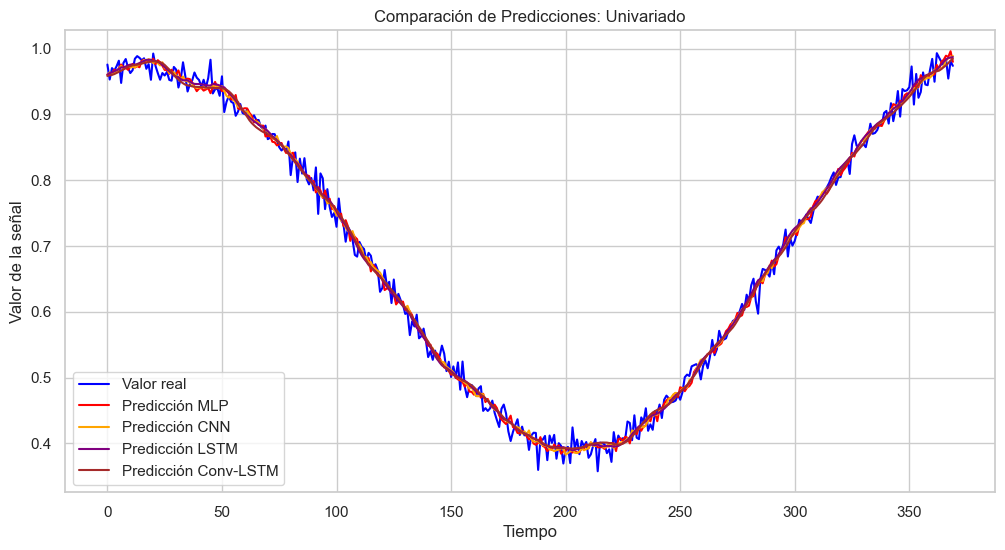

In [49]:
# Graficar predicciones univariadas
plt.figure(figsize=(12, 6))
plt.plot(y_test_uni, label='Valor real', color='blue')
plt.plot(y_pred_mlp_uni, label='Predicción MLP', color='red')
plt.plot(y_pred_cnn_uni, label='Predicción CNN', color='orange')
plt.plot(y_pred_lstm_uni, label='Predicción LSTM', color='purple')
plt.plot(y_pred_convlstm_uni, label='Predicción Conv-LSTM', color='brown')
plt.legend()
plt.title('Comparación de Predicciones: Univariado')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la señal')
plt.show()

##### Gráficos de las predicciones de los datos multivariados

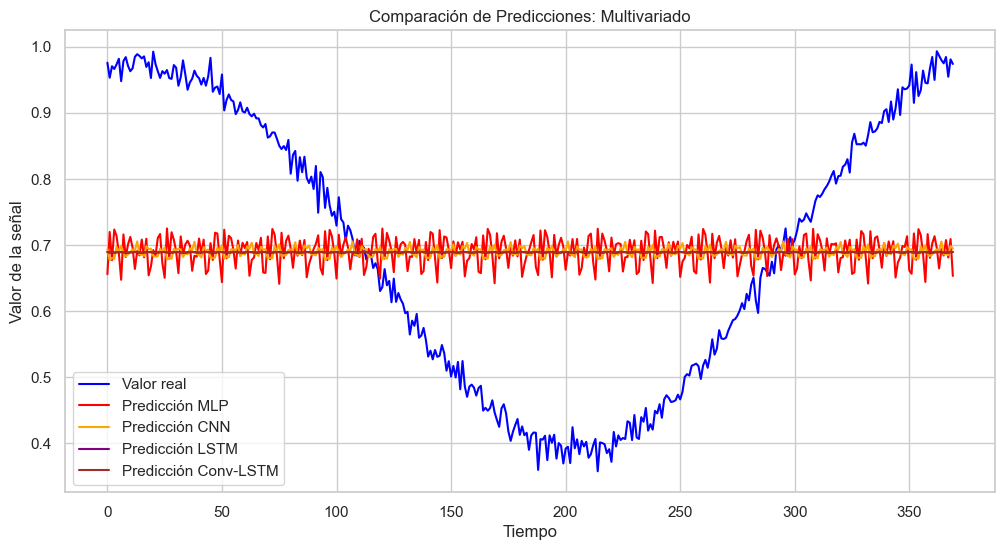

In [50]:
# Graficar predicciones multivariadas
plt.figure(figsize=(12, 6))
plt.plot(y_test_multi, label='Valor real', color='blue')
plt.plot(y_pred_mlp_multi, label='Predicción MLP', color='red')
plt.plot(y_pred_cnn_multi, label='Predicción CNN', color='orange')
plt.plot(y_pred_lstm_multi, label='Predicción LSTM', color='purple')
plt.plot(y_pred_convlstm_multi, label='Predicción Conv-LSTM', color='brown')
plt.legend()
plt.title('Comparación de Predicciones: Multivariado')
plt.xlabel('Tiempo')
plt.ylabel('Valor de la señal')
plt.show()

##### Optimización con Optuna

In [ ]:
# Ejemplo de optimización para el mejor modelo (MLP Univariado)
def objective(trial):
    model = Sequential()
    model.add(Dense(units=trial.suggest_int('units', 32, 128), activation='relu', input_shape=(X_train_uni_mlp.shape[1],)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    model.fit(X_train_uni_mlp, y_train_uni, validation_data=(X_test_uni_mlp, y_test_uni), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)
    
    y_pred = model.predict(X_test_uni_mlp)
    mse = mean_squared_error(y_test_uni, y_pred)
    
    return mse

# Crear el estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Mejor valor de los parámetros
print(f"Mejores parámetros: {study.best_params}")

## 3. Clasificación de series de tiempo